### Import libraries

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data
* Download train and test set
* Apply transforms
* Define dataloaders

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [6]:
train_dir = 'mednode_dataset'
batch_size = 8
num_workers = 4
test_size = 0.30
random_seed = 24

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
test_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [8]:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(test_size * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          sampler=test_sampler,
                                          num_workers=num_workers)

In [9]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

### Explore dataset

In [21]:
total_batch_sizes = { 'train': len(train_loader), 'test': len(test_loader) }

In [22]:
total_batch_sizes

{'train': 22, 'test': 10}

In [23]:
class_names = train_data.classes

print(class_names)

['melanoma', 'naevus']


In [27]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)  

In [16]:
inputs, classes = next(iter(dataloaders['train']))

In [17]:
out = torchvision.utils.make_grid(inputs)

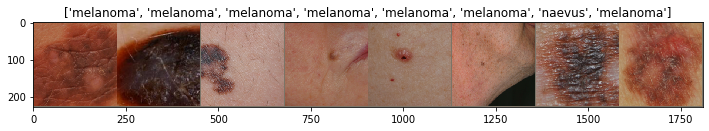

In [18]:
imshow(out, title=[class_names[x] for x in classes])

### Transfer learning
* Load the pretrained model, Resnet18
* Define parameters
* The criterion to minimize in the loss function. Given this is a classification model, we will look to minimize the cross-entropy loss
* A simple SGD optimizer with momentum which accelerate gradients vectors in the right directions and hence leads to faster converging
* Scheduler to decay Learning Rate by a factor of 0.1 every 7 epochs


In [10]:
from torchvision import models

In [11]:
model = models.resnet18(pretrained=True) 

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [14]:
count = 0 
for child in model.children():
    count+=1
    
count

10

### Finetuning the top layers
* Freeze the first 6 layers

In [15]:
count = 0 
for child in model.children():
    count+=1
    if count < 7:
        for param in child.parameters():
            param.requires_grad = False

In [16]:
model.fc = nn.Linear(num_ftrs, 2)

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define training and test phase
* scheduler.step() will set up the scheduler for each step in order to decay the learning rate
* Each epoch has a training and test phase
* model.train() will set the pre-trained model into training mode. This is only available for pre-trained models
* running_loss will keep track of the loss at each iteration
* running_corrects keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model 
* outputs is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch

In [18]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            
            if phase == 'train':
                model.train()  
                
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete')
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [24]:
model = train_model(model, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 5.7032 Acc: 0.7159
test Loss: 7.8028 Acc: 0.6375
Epoch 1/4
----------
train Loss: 5.4278 Acc: 0.7443
test Loss: 7.7450 Acc: 0.6250
Epoch 2/4
----------
train Loss: 5.8311 Acc: 0.7557
test Loss: 8.1047 Acc: 0.6250
Epoch 3/4
----------
train Loss: 6.0699 Acc: 0.7273
test Loss: 5.2109 Acc: 0.6750
Epoch 4/4
----------
train Loss: 6.3454 Acc: 0.7216
test Loss: 7.7352 Acc: 0.6375
Training complete
Best val Acc: 0.675000


### Model Evaluation

In [25]:
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))


Accuracy of the model on the test images: 64.86486486486487%


Acutal label 0


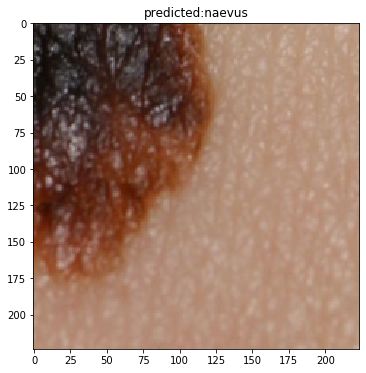

Acutal label 0


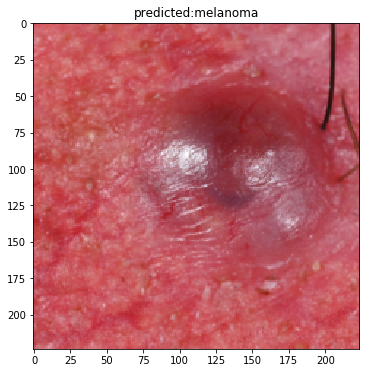

Acutal label 1


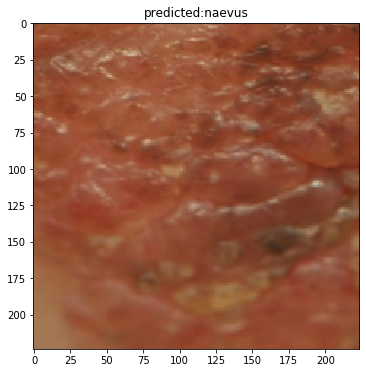

Acutal label 1


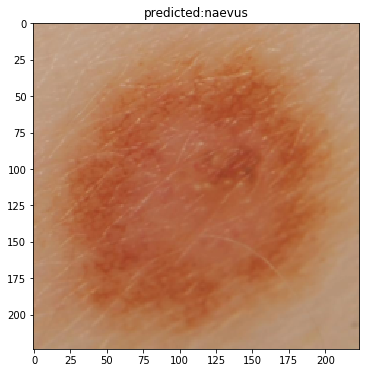

Acutal label 0


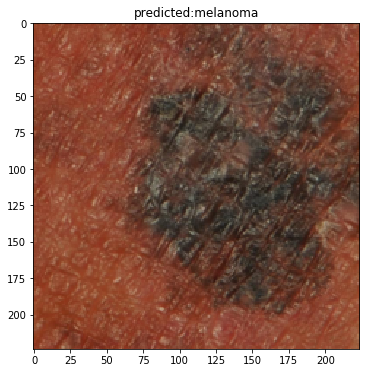

Acutal label 1


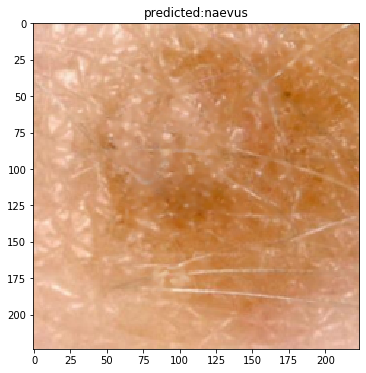

Acutal label 1


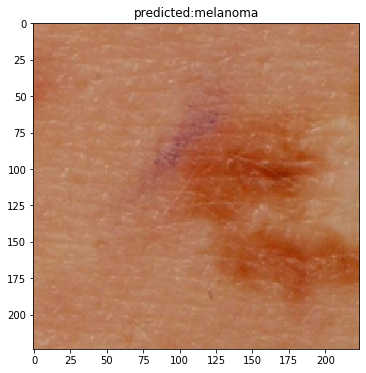

Acutal label 1


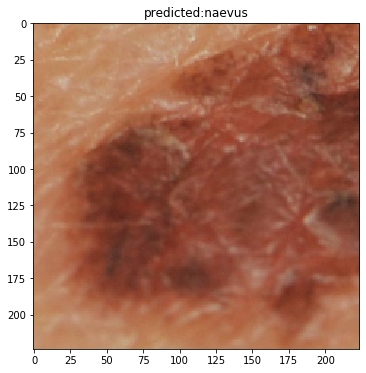

In [28]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
        
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Acutal label", np.array(labels)[j])
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])
        
    